In [2]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
from time import time

from scipy.cluster import hierarchy

import matplotlib.pyplot as plt
%matplotlib inline

# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) <br>Advanced Dimensonality Reduction Techniques
Week 8 | Day 1

### LEARNING OBJECTIVES
*After this lesson, you will be able to:*
- Explain the curse of dimensionality
- Describe the pros and cons of increasing and decreasing dimensonality
- Utilize t-SNE efficiently in sklearn

## Recap:



Last week, we discussed how to reduce the dimensionality of our data and some methods to do so:

- K-Means
- Hierarchical Agglomorative Clustering (HAC)
- DBSCAN
- PCA

## But why bother?

## Benefits:

- Reduce memory requirements
- Decrease model runtime
- Eliminate non-informative features
- Reduce multi-collinearity
- Allow for visualization

## But there is one more:

- Avoid the **curse of dimensionalty** 

<img src="https://media.giphy.com/media/l0HlE9EUnP140oQYE/source.gif" width=500>

## What is the curse of dimensonality?

As we increase the number of dimensions (feature space), we effectively increase the "empty space" that our samples "live in"

## Example - 1D

<img src="http://i.imgur.com/qFsUpEF.png">

- Taken from  http://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/

## Add a dimension

<img src="http://i.imgur.com/twehmdw.png">

## And another

<img src="http://i.imgur.com/tgLFRat.png">

We can now see that the amount of "space" is growing at an enormous rate which is causing our samples to move further and further away from one another. It can actually be shown that as we increase the dimensionality to infinity, the distance between the nearest neighbors and the furthest approaches parity. Because of this euclidean distances become increasingly meaningless as dimensions rise.

So that is the downside. Are there any upsides to increasing feature space?

## Yes.

## Is this a tradeoff thing again?

## Yes.

With certain classifiers (linear) - going from a dimensionality that is too low doesn't allow us to effectively create a separating hyperplane. For example in our dogs and cats example, in 1d and 2d, we couldn't insert a separating plane to classify them correctly.

## In 3D, we can

<img src="http://i.imgur.com/yk6eQiH.png">

## But if we go to far....

<img src="http://i.imgur.com/GcbscuZ.png">

We can overfit our data as a consequence of the curse of dimensionality


## SVM  example

A support vector machine creates a separating plane with as much margin between classes as it can. But it is a linear boundary. Here, we can't use a linear plane to separate this.

<img src="http://i.imgur.com/j0hyJ63.png">

## But we can create a mapping from 1D to 2D by squaring each X1 feature

Now we can separate with a 1D line

<img src="http://i.imgur.com/lEYQsaj.png">

This process of mapping from one dimension to a higher dimensionality can be done at a very low computational cost in SVMs using something called the "kernel trick"

## But, now, back to the curse part of higher dimensionality...

And all that space...

<img src="https://d13yacurqjgara.cloudfront.net/users/626327/screenshots/2618501/400.gif">

## Does it hurt all classifiers equally?

## No.

>  "**Classifiers that tend to model non-linear decision boundaries very accurately (e.g. neural networks, KNN classifiers, decision trees) do not generalize well and are prone to overfitting.** Therefore, the dimensionality should be kept relatively low when these classifiers are used. If a classifier is used that generalizes easily (e.g. naive Bayesian, linear classifier), then the number of used features can be higher since the classifier itself is less expressive."

## There is a corollary to the curse of dimensionality, however, known as the "blessing of non-uniformity"

> "In most applications examples are not spread uniformly throughout
the instance space, but are concentrated on or near
a **lower-dimensional manifold**. For example, k-nearest neighbor
works quite well for handwritten digit recognition even
though images of digits have one dimension per pixel, because
the space of digit images is much smaller than the
space of all possible images." -Pedro Domingos

## Ok, so how does this manifold thing work?

## You know what this is:

<img src="http://www.dbtechnology.co.uk/images/globe.jpg">

## So how do we make it look like this?

<img src="https://stuff.mit.edu/afs/athena/system/amd64_deb50/os/usr/share/gnome-panel/pixmaps/world_map-960.png">

## Turns out there are a lot of ways to do that...

<img src="https://imgs.xkcd.com/comics/map_projections.png" width=500>

## And similarly, there are tons of ways to do that with our data

- K-Means
- DBSCAN
- Hierarchical Clustering
- PCA
- t-SNE
- Isomaping
- Multi-Dimensional Scaling
- Modified Local Linear Embedding (MLLE)
- Random Projections
- Spectral Embedding
- Local Tangent Space Alignment
- Autoencoders
- ...

## So manifold learning is the same idea conceptually

Also known as multi-dimensional scaling, embedding, dimensionality reduction...

## We want to map a higher dimensional representation to a lower dimensional one

## The key is to represent the data such that the distances in the lower dimensional representation are representative of the distances in the higher dimensional data.

<img src="http://i.imgur.com/43ZExWq.png" width=600>

## Well  great, but how?

By mininizing some cost function that measures the similarities of the data in the higher dimension and the lower dimensional map

## Wait, but I thought that was PCA?

Yes, PCA reduces features to <em>linear combination</em> of higher dimensional features

<img src="http://i.imgur.com/1rkBvas.png">

## But PCA is not necessarily the best representation for all scenarios

If our data is non-linear...

<img src="http://i.imgur.com/oyrIlVx.png">

## PCA seeks to maximize variance (min sq. errors) which tends to preserve large pairwise distances

Doesn't tend to produce the best mapping in lower dimensions

## Example

In [3]:
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

In [9]:
# Scale and visualize the embedding vectors
def plot_embedding_color(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    fig = plt.figure(figsize=(15,8))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Computing PCA projection


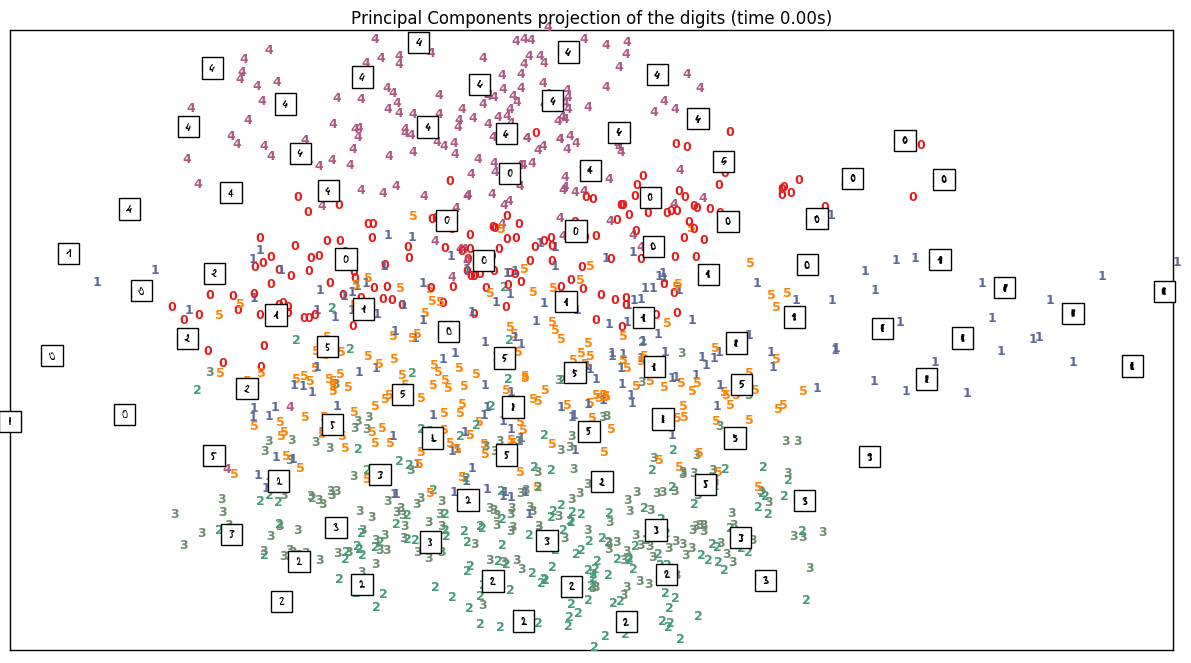

In [12]:
print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding_color(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))

In [13]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    fig = plt.figure(figsize=(15,8))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color='k', fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Computing PCA projection


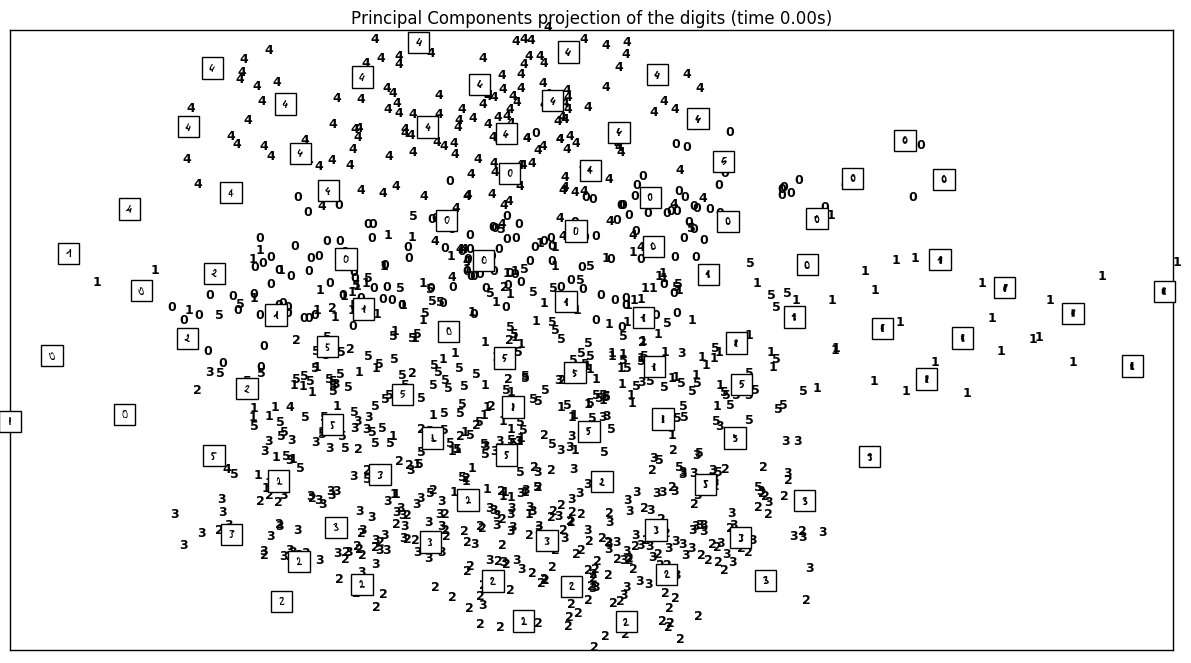

In [14]:
print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))

## So what does work?

** Preserving Local distances  **

## Example

<img src="http://i.imgur.com/ICb690x.png">

<img src="http://i.imgur.com/M8d0ljj.png">

<img src="http://i.imgur.com/tFrZfdb.png">

## Iso Mapping

Attempts to map using geodesic distances over the manifold.

<img src="http://i.imgur.com/i6qakh0.png">

## Isomap

Computing Isomap embedding
Done.


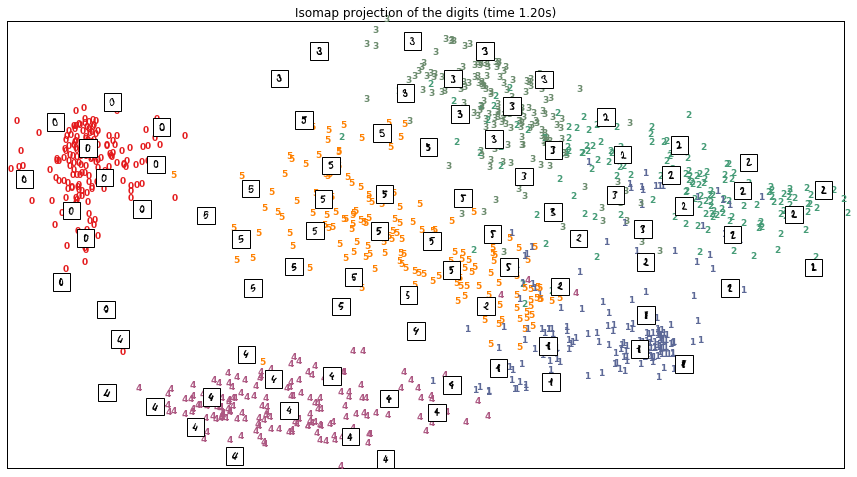

In [29]:
# Isomap projection of the digits dataset
print("Computing Isomap embedding")
t0 = time()
X_iso = manifold.Isomap(n_neighbors, n_components=2).fit_transform(X)
print("Done.")
plot_embedding_color(X_iso,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))

Computing Isomap embedding
Done.


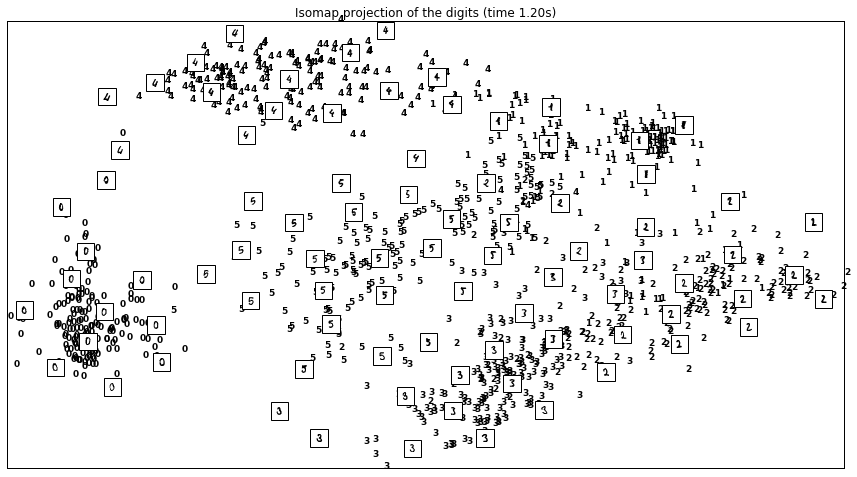

In [30]:
# Isomap projection of the digits dataset
print("Computing Isomap embedding")
t0 = time()
X_iso = manifold.Isomap(n_neighbors, n_components=2).fit_transform(X)
print("Done.")
plot_embedding(X_iso,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))

## Better, but still not quite there...

## Enter t-SNE

t-SNE uses gradient descent on something called the KL divergence - The effect of this is to keep things that are close in high dimensional space to be close in low dimensional space, but things that are far are allowed to be even further apart.

Computing t-SNE embedding


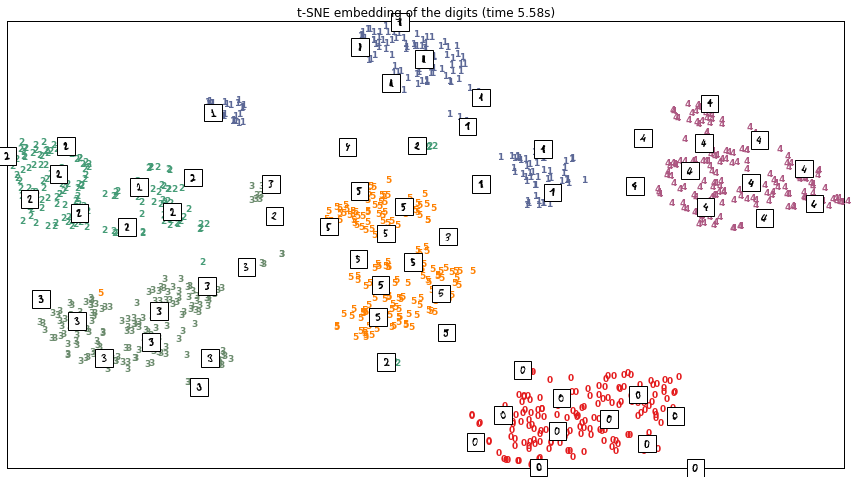

In [31]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding_color(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()

Computing t-SNE embedding


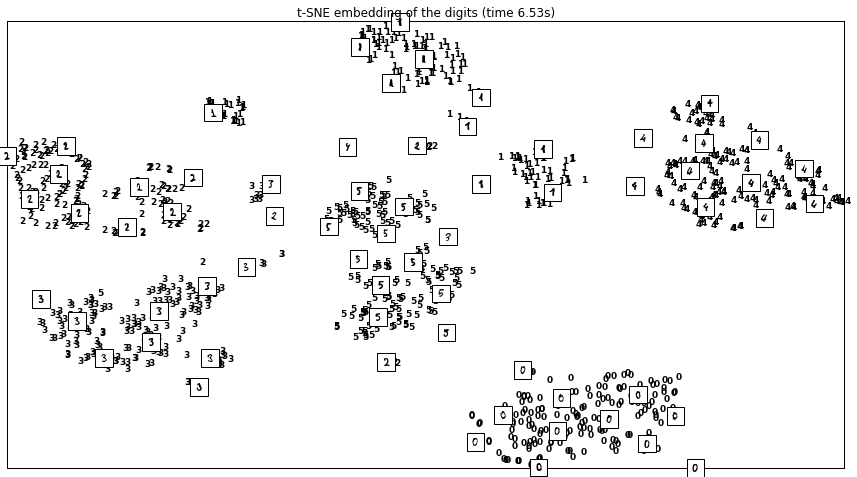

In [32]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()

## t-SNE

[t-SNE Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

<img src="http://i.imgur.com/V2C4JtX.png">

## Independent Practice

1. Read [the following](http://distill.pub/2016/misread-tsne/) on t-SNE and how to effectively utilize it

2. Check out the sklearn documentation on manifold learning in sk-learn and using one of the datasets we've worked with (iris, airport delays, wine data, etc.) compare and contrast the results using PCA and t-SNE. Which produces the best result?

## Conclusion

- Beware the curse of dimensonality
- Sometimes though, you need to map to a higher dimensionality
- PCA is great for dimensonality reduction when you want to preserve large pairwise distances
- Because of that it fails for effective visualization
- t-SNE is state-of-the-art for visualizing high dimensonal data
- You need to understand the parameters that go into t-SNE - **they matter**
- Cluster size and large distances may not be meaninful with t-SNE

## Additional Materials

[Manifold Learning](http://scikit-learn.org/stable/modules/manifold.html#manifold)<br>
[Effectively Using t-SNE](http://distill.pub/2016/misread-tsne)<br>
[t-SNE](http://lvdmaaten.github.io/tsne/)<br>
[Facebook Talks - t-SNE](https://www.youtube.com/watch?v=EMD106bB2vY&t=2860s)<br>
[t-SNE on CNN features from Images](http://cs.stanford.edu/people/karpathy/cnnembed/)<br>
[sklearn t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
[Google Tech Talks t-SNE](https://www.youtube.com/watch?v=RJVL80Gg3lA&t=246s)